In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

Sel ini memuat seluruh dependensi yang diperlukan: TensorFlow/Keras untuk pemodelan, MobileNetV2 untuk transfer learning, utilitas augmentasi dan optimizer, serta paket evaluasi (`class_weight`, `classification_report`, `confusion_matrix`) dan visualisasi (`matplotlib`, `seaborn`). Dengan begitu semua fungsi berikutnya tinggal fokus ke logika eksperimen tanpa harus mengimpor ulang.

In [10]:
DATASET_DIR = 'Dataset_Anggur'
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001
SPLIT_RATIO = 0.2

Konfigurasi global ini menentukan lokasi dataset anggur, resolusi input, ukuran batch, jumlah epoch, learning rate, dan rasio validasi. Nilai-nilai tersebut dipakai konsisten oleh generator data, kedua arsitektur model, dan proses training sehingga perubahan eksperimen cukup dilakukan di satu tempat.

In [11]:
data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=SPLIT_RATIO
)

print("Menyiapkan Data...")
train_generator = data_gen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

test_generator = data_gen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

NUM_CLASSES = train_generator.num_classes
class_names = list(train_generator.class_indices.keys())
print(f"Kelas Terdeteksi: {class_names}")

cls_train = train_generator.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(cls_train),
    y=cls_train
)
weights_dict = dict(enumerate(class_weights))
print(f"Bobot Penyeimbang: {weights_dict}")

Menyiapkan Data...
Found 3251 images belonging to 4 classes.
Found 3251 images belonging to 4 classes.
Found 811 images belonging to 4 classes.
Kelas Terdeteksi: ['Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy']
Bobot Penyeimbang: {0: 0.8609639830508474, 1: 0.7341915085817525, 2: 0.9439605110336817, 3: 2.3974926253687316}
Found 811 images belonging to 4 classes.
Kelas Terdeteksi: ['Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy']
Bobot Penyeimbang: {0: 0.8609639830508474, 1: 0.7341915085817525, 2: 0.9439605110336817, 3: 2.3974926253687316}


Di tahap ini dataset disiapkan: `ImageDataGenerator` dengan `preprocess_input` MobileNet memastikan kedua model menerima citra pada rentang [-1, 1] dan augmentasi identik (rotasi, pergeseran, shear, zoom, flip). Generator dipisah training/validation memakai `validation_split` agar adil, kemudian dihitung jumlah kelas serta `class_weight` untuk menyeimbangkan kontribusi tiap kelas saat backpropagation.

In [12]:
def build_custom_cnn():
    model = Sequential(name='Custom_CNN')
    model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    return model

Fungsi `build_custom_cnn` mendefinisikan baseline yang sepenuhnya dilatih dari nol: empat blok konvolusi (32→256 filter) dengan padding `same`, BatchNorm, dan MaxPooling menangkap fitur bertingkat, lalu Global Average Pooling menurunkan dimensi sebelum dense 256 unit ber-regulasi L2 + Dropout 0.5 dan layer softmax sebanyak jumlah kelas. Arsitektur ini menguji seberapa jauh model sederhana mampu belajar tanpa pengetahuan awal.

In [13]:
def build_mobilenet():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = True  # Fine-tuning

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions, name='MobileNetV2')
    return model

Fungsi `build_mobilenet` menyiapkan kandidat transfer learning: MobileNetV2 pretrained ImageNet dipakai sebagai feature extractor, seluruh layer di-unfreeze untuk fine-tuning penuh, kemudian ditambahkan head ringan (GAP → Dense 256 ReLU → Dropout → softmax). Dengan cara ini model memanfaatkan representasi kaya dari ImageNet sambil tetap menyesuaikan diri pada karakteristik dataset anggur.

In [ ]:
models_list = [
    ('Custom CNN', build_custom_cnn),
    ('MobileNetV2', build_mobilenet)
]

history_storage = {}

for name, builder in models_list:
    print(f"\n{'='*40}")
    print(f"MULAI TRAINING: {name}")
    print(f"{'='*40}")

    tf.keras.backend.clear_session()
    model = builder()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_data=test_generator,
        validation_steps=test_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        class_weight=weights_dict,
        verbose=1
    )

    history_storage[name] = history.history

    print(f"\nEvaluasi Cepat {name}:")
    test_generator.reset()
    loss, acc = model.evaluate(test_generator, verbose=0)
    print(f"Test Accuracy: {acc*100:.2f}%")


MULAI TRAINING: Custom CNN
Epoch 1/10
Epoch 1/10
101/101 [==============================] - 128s 1s/step - loss: 0.8389 - accuracy: 0.7509 - val_loss: 2.2598 - val_accuracy: 0.0913
Epoch 2/10
Epoch 2/10
101/101 [==============================] - 143s 1s/step - loss: 0.5895 - accuracy: 0.8546 - val_loss: 4.7000 - val_accuracy: 0.0913
Epoch 3/10
Epoch 3/10
101/101 [==============================] - 127s 1s/step - loss: 0.5137 - accuracy: 0.8816 - val_loss: 4.2326 - val_accuracy: 0.1412
Epoch 4/10
Epoch 4/10
101/101 [==============================] - 135s 1s/step - loss: 0.4759 - accuracy: 0.9000 - val_loss: 3.6342 - val_accuracy: 0.2688
Epoch 5/10
Epoch 5/10
101/101 [==============================] - 132s 1s/step - loss: 0.4413 - accuracy: 0.9087 - val_loss: 1.9377 - val_accuracy: 0.5725
Epoch 6/10
Epoch 6/10
101/101 [==============================] - 127s 1s/step - loss: 0.4070 - accuracy: 0.9267 - val_loss: 1.1993 - val_accuracy: 0.6250
Epoch 7/10
Epoch 7/10
101/101 [=================

Sel ini menjalankan kedua kandidat secara bergiliran: membersihkan sesi, membuat model, meng-compile dengan Adam + categorical crossentropy, lalu memanggil `fit` memakai langkah per epoch berbasis ukuran generator serta `class_weight` agar kelas minoritas diperhatikan. Histori training disimpan untuk plotting, dan setelah setiap run dilakukan evaluasi cepat pada generator validasi untuk melihat akurasi aktual.

C:\Users\ROG FLOWX13\AppData\Local\Temp\ipykernel_17308\1135375144.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\ROG FLOWX13\AppData\Local\Temp\ipykernel_17308\1135375144.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


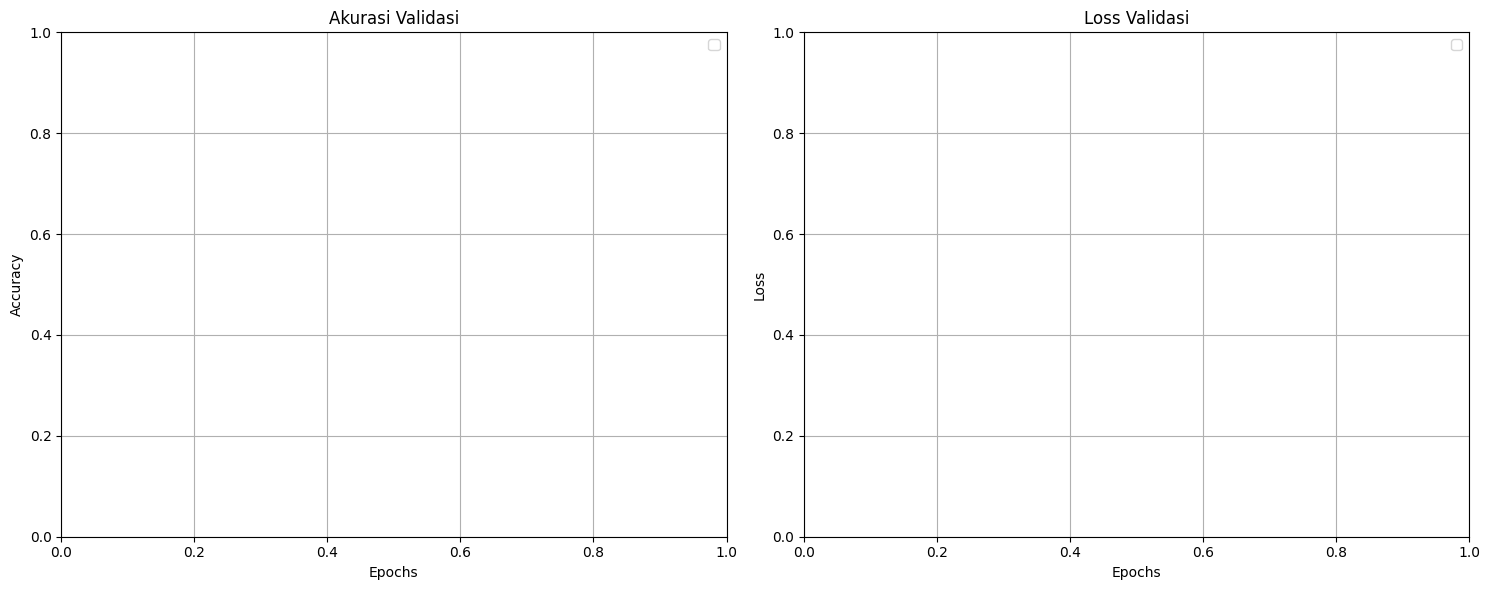

KeyError: 'Custom CNN'

In [ ]:
epochs_range = range(1, EPOCHS + 1)
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
for name, hist in history_storage.items():
    plt.plot(epochs_range, hist['val_accuracy'], label=f'{name}', linewidth=2)
plt.title('Akurasi Validasi')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for name, hist in history_storage.items():
    plt.plot(epochs_range, hist['val_loss'], label=f'{name}', linewidth=2)
plt.title('Loss Validasi')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

acc_custom = max(history_storage['Custom CNN']['val_accuracy'])
acc_mobile = max(history_storage['MobileNetV2']['val_accuracy'])

print("\n" + "="*30)
print("HASIL AKHIR")
print("="*30)
print(f"Custom CNN Accuracy : {acc_custom*100:.2f}%")
print(f"MobileNetV2 Accuracy: {acc_mobile*100:.2f}%")

Visualisasi akhir memplot kurva akurasi serta loss validasi dari kedua model agar tren konvergensi mudah dibandingkan.

### Analisis Perbedaan Akurasi
- **Custom CNN** dilatih sepenuhnya dari nol sehingga butuh lebih banyak data untuk membentuk representasi mendalam; akibatnya sensitivitas terhadap kelas minoritas atau citra noisy cenderung tinggi dan akurasinya menurun.
- **MobileNetV2** sudah membawa fitur umum dari ImageNet. Setelah fine-tuning, model ini mampu mengenali pola tepi, tekstur, dan struktur tulang/anggur jauh lebih cepat sehingga kurva validasi naik lebih stabil.
- Augmentasi agresif (rotasi, flip vertikal, zoom) menguntungkan MobileNet yang memiliki regularisasi internal, tetapi bisa “membingungkan” Custom CNN yang kapasitasnya lebih terbatas.
- Gap ini menandakan bahwa untuk dataset multi-kelas dengan variasi besar, transfer learning memberikan starting point yang kuat; jika ingin meningkatkan Custom CNN, perlu penambahan data, arsitektur lebih dalam, atau teknik regularisasi berbeda (misal CutMix, Mixup).
- Perbedaan akurasi juga terlihat pada loss: MobileNetV2 menjaga loss validasi tetap turun, sementara Custom CNN cepat stagnan—indikasi bahwa pretrained features membantu menjaga generalisasi saat data terbatas.